In [ ]:
# !pip install -q google-cloud-bigquery google-cloud-bigquery-storage db-dtypes pandas pyarrow
import pandas as pd
import numpy as np
import altair as alt
from google.cloud import bigquery
from google.colab import auth
from google.cloud.bigquery import magics
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [ ]:
auth.authenticate_user()
print('Authenticated')
project_id = '########' #@param {type: "string"}
# Set the default project id for %bigquery magic
magics.context.project = project_id
client = bigquery.Client(project=project_id)

Authenticated


In [3]:
%load_ext google.cloud.bigquery

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/__init__.py:237: FutureWarning: %load_ext google.cloud.bigquery is deprecated. Install bigquery-magics package and use `%load_ext bigquery_magics`, instead.
  warnings.warn(


#**MACHINE EVENTS TABLE DATA** -

In [4]:
%%bigquery machine_events_data
SELECT * FROM `google.com:google-cluster-data`.clusterdata_2019_a.machine_events

Query is running:   0%|          |

Downloading:   0%|          |

#**MACHINE EVENTS TABLE INSIGHTS** -

In [5]:
%%bigquery machine_events_insights
SELECT capacity.cpus AS cpu_cap, capacity.memory AS memory_cap, COUNT(DISTINCT machine_id) AS num_machines
FROM `google.com:google-cluster-data`.clusterdata_2019_a.machine_events GROUP BY 1,2

Query is running:   0%|          |

Downloading:   0%|          |

#**COLLECTION EVENTS TABLE DATA** -

In [6]:
%%bigquery collection_events_data
SELECT * FROM `google.com:google-cluster-data`.clusterdata_2019_a.collection_events

Query is running:   0%|          |

Downloading:   0%|          |

#**COLLECTION EVENTS TABLE INSIGHTS** -

In [7]:
%%bigquery collection_events_insights
SELECT COUNT(DISTINCT collection_id) AS collections FROM
`google.com:google-cluster-data`.clusterdata_2019_a.collection_events

Query is running:   0%|          |

Downloading:   0%|          |

#**INSTANCE EVENTS TABLE DATA** -

In [8]:
%%bigquery instance_events_data
SELECT * FROM `google.com:google-cluster-data`.clusterdata_2019_a.instance_events LIMIT 10000000

Query is running:   0%|          |

Downloading:   0%|          |

#**MACHINE ATTRIBUTES TABLE DATA** -

In [9]:
%%bigquery machine_attributes_data
SELECT * FROM `google.com:google-cluster-data`.clusterdata_2019_a.machine_attributes

Query is running:   0%|          |

Downloading:   0%|          |

#**INSTANCE USAGE DATA** -

In [10]:
%%bigquery instance_usage_data
SELECT * FROM `google.com:google-cluster-data`.clusterdata_2019_a.instance_usage LIMIT 10000000

Query is running:   0%|          |

Downloading:   0%|          |

# **DataFrames -**
machine_events_data, machine_events_insights, collection_events_data, collection_events_insights, instance_events_data, machine_attributes_data

In [11]:
machine_events_data = machine_events_data.dropna(subset=['machine_id', 'capacity'])
# # machine_events_data['machine_id'].value_counts()[lambda x: x > 1]
machine_events_data['cpu_capacity'] = machine_events_data['capacity'].apply(lambda x: x['cpus'])
machine_events_data['mem_capacity'] = machine_events_data['capacity'].apply(lambda x: x['memory'])
machine_events_data = machine_events_data.drop(columns=['switch_id', 'platform_id', 'missing_data_reason', 'capacity'], errors='ignore')
machine_events_data = machine_events_data[(machine_events_data['cpu_capacity'] > 0) & (machine_events_data['mem_capacity'] > 0)]
machine_events_data

,time,machine_id,type,cpu_capacity,mem_capacity
459,0,92126449465,1,1.000000,0.500000
460,1115701818978,92126449465,1,1.000000,0.500000
461,0,92065249319,1,1.000000,0.500000
462,1040224094227,92065249319,1,1.000000,0.500000
463,0,92046587157,1,1.000000,0.500000
...,...,...,...,...,...
46214,2294902521428,398063445417,3,0.591797,0.333496
46215,2374544210585,398963927990,3,0.591797,0.333496
46216,1689220940652,385613830661,3,0.591797,0.333496
46217,1963973255182,394444272211,3,0.591797,0.333496


In [12]:
machine_means = machine_events_data.groupby(['machine_id', 'type']).agg({'cpu_capacity': 'mean','mem_capacity': 'mean'}).reset_index()
capacity_by_type = machine_means.groupby('type').agg({'cpu_capacity': 'mean','mem_capacity': 'mean'}).reset_index()
machine_counts = machine_means['type'].value_counts().sort_index()
capacity_by_type['count'] = capacity_by_type['type'].map(machine_counts)
print("Mean capacities by machine type:")
print(capacity_by_type)

Mean capacities by machine type:
   type  cpu_capacity  mem_capacity  count
0     1      0.675413      0.395243   9670
1     2      0.675600      0.395387   9650
2     3      0.884770      0.777398    486


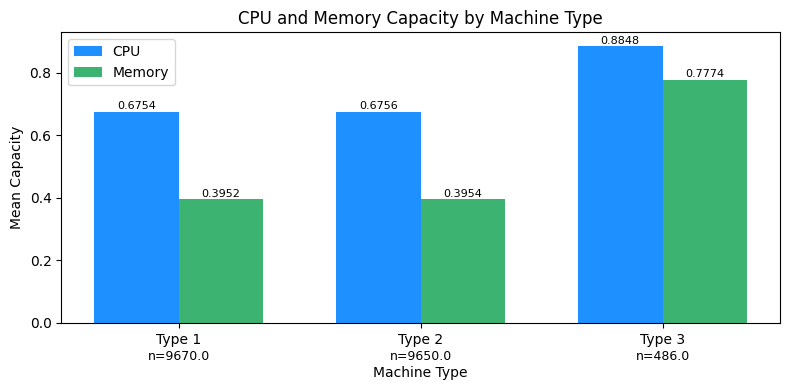

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))
bar_width = 0.35
x = np.arange(len(capacity_by_type))
cpu_bars = ax.bar(x - bar_width/2, capacity_by_type['cpu_capacity'],  bar_width, label='CPU', color='dodgerblue')
mem_bars = ax.bar(x + bar_width/2, capacity_by_type['mem_capacity'], bar_width, label='Memory', color='mediumseagreen')

ax.set_xlabel('Machine Type', labelpad=14)
ax.set_ylabel('Mean Capacity')
ax.set_title('CPU and Memory Capacity by Machine Type')
ax.set_xticks(x)
ax.set_xticklabels([f'Type {t}' for t in capacity_by_type['type']])
ax.legend(loc='upper left')

for i in range(len(capacity_by_type)):
    counts = capacity_by_type.iloc[i]['count']
    ax.text(i, -0.12, f'n={counts}', ha='center', fontsize=9)

for bar in cpu_bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.008, f'{bar.get_height():.4f}', ha='center', fontsize=8)

for bar in mem_bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.008, f'{bar.get_height():.4f}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

In [14]:
machine_data = machine_events_data.drop_duplicates(subset=['machine_id'])
machine_data.dropna(inplace=True)
machine_data

,time,machine_id,type,cpu_capacity,mem_capacity
459,0,92126449465,1,1.000000,0.500000
461,0,92065249319,1,1.000000,0.500000
463,0,92046587157,1,1.000000,0.500000
465,0,92048363107,1,1.000000,0.500000
467,0,92035409124,1,1.000000,0.500000
...,...,...,...,...,...
46208,2545554299697,399833620242,3,0.591797,0.333496
46214,2294902521428,398063445417,3,0.591797,0.333496
46215,2374544210585,398963927990,3,0.591797,0.333496
46217,1963973255182,394444272211,3,0.591797,0.333496


In [15]:
instance_events_data.head()

,time,type,collection_id,scheduling_class,missing_type,collection_type,priority,alloc_collection_id,instance_index,machine_id,alloc_instance_index,resource_request,constraint
0,443298738600,6,330587180564,2,<NA>,1,101,0,195,4667400959,-1,"{'cpus': 0.01171875, 'memory': 0.01116943359375}",[{'name': '9eCGRtl6XN5GQoOYGEjKtupBbtUoOaOPYRF...
1,261559863676,6,330587183065,2,<NA>,1,101,0,729,376492811243,-1,"{'cpus': 0.011566162109375, 'memory': 0.011169...",[{'name': '9eCGRtl6XN5GQoOYGEjKtupBbtUoOaOPYRF...
2,2653416634575,10,330587135936,2,<NA>,1,101,0,304,21109492,-1,"{'cpus': 0.01953125, 'memory': 0.01116943359375}",[{'name': '9eCGRtl6XN5GQoOYGEjKtupBbtUoOaOPYRF...
3,258894487488,3,39516997747,2,<NA>,0,0,0,1503,96915406618,-1,"{'cpus': 0.001598358154296875, 'memory': 0.000...",[]
4,39753013568,2,39516997747,2,<NA>,0,0,0,3659,<NA>,-1,"{'cpus': 0.0019989013671875, 'memory': 0.00020...",[]


In [16]:
instance_e_data = instance_events_data.drop(columns=['missing_type', 'alloc_instance_index', 'constraint'])
instance_e_data

,time,type,collection_id,scheduling_class,collection_type,priority,alloc_collection_id,instance_index,machine_id,resource_request
0,443298738600,6,330587180564,2,1,101,0,195,4667400959,"{'cpus': 0.01171875, 'memory': 0.01116943359375}"
1,261559863676,6,330587183065,2,1,101,0,729,376492811243,"{'cpus': 0.011566162109375, 'memory': 0.011169..."
2,2653416634575,10,330587135936,2,1,101,0,304,21109492,"{'cpus': 0.01953125, 'memory': 0.01116943359375}"
3,258894487488,3,39516997747,2,0,0,0,1503,96915406618,"{'cpus': 0.001598358154296875, 'memory': 0.000..."
4,39753013568,2,39516997747,2,0,0,0,3659,<NA>,"{'cpus': 0.0019989013671875, 'memory': 0.00020..."
...,...,...,...,...,...,...,...,...,...,...
9999995,1201558986210,0,330587209928,2,0,360,330587118384,321,<NA>,"{'cpus': 0.0228271484375, 'memory': 0.00130271..."
9999996,2259436429051,0,330587209928,2,0,360,330587118384,178,<NA>,"{'cpus': 0.024322509765625, 'memory': 0.001302..."
9999997,2424050564914,4,330587209928,2,0,360,330587118384,472,143876685889,"{'cpus': 0.024322509765625, 'memory': 0.001302..."
9999998,2017038004484,0,330587209928,2,0,360,330587118384,722,<NA>,"{'cpus': 0.0228271484375, 'memory': 0.00130271..."


In [17]:
instance_data = pd.merge(instance_usage_data, instance_e_data, on=['instance_index', 'collection_id', 'machine_id'], how='inner')
instance_data = instance_data.dropna(subset=['resource_request'])
instance_data

,start_time,end_time,collection_id,instance_index,machine_id,alloc_collection_id_x,alloc_instance_index,collection_type_x,average_usage,maximum_usage,...,sample_rate,cpu_usage_distribution,tail_cpu_usage_distribution,time,type,scheduling_class,collection_type_y,priority,alloc_collection_id_y,resource_request
0,2399100000000,2399400000000,6779010793,2,62183393288,0,-1,0,"{'cpus': 0.0001316070556640625, 'memory': 0.00...","{'cpus': 0.0005359649658203125, 'memory': 0.00...",...,1.000000,"[9.72747802734375e-05, 0.00010204315185546875,...","[0.00017547607421875, 0.00018024444580078125, ...",2494122107199,10,2,0,200,0,"{'cpus': 0.00026416778564453125, 'memory': 0.0..."
1,1158900000000,1159200000000,381666622735,10,1579760836,0,-1,0,"{'cpus': 0.000110626220703125, 'memory': 0.003...","{'cpus': 0.00116729736328125, 'memory': 0.0038...",...,1.000000,"[7.62939453125e-05, 8.678436279296875e-05, 9.3...","[0.0001316070556640625, 0.00014495849609375, 0...",1024358166077,3,1,0,200,0,"{'cpus': 0.00035190582275390625, 'memory': 0.0..."
2,2406300000000,2406600000000,220585809472,38,71877861914,220585668772,38,0,"{'cpus': 0.00042438507080078125, 'memory': 0.0...","{'cpus': 0.00373077392578125, 'memory': 0.0002...",...,1.000000,"[0.00015735626220703125, 0.00017547607421875, ...","[0.0007505416870117188, 0.0007772445678710938,...",1364439988599,3,2,0,205,220585668772,"{'cpus': 0.00823974609375, 'memory': 0.0003175..."
3,905100000000,905400000000,278244174157,18,3098304099,278244173892,18,0,"{'cpus': 0.003299713134765625, 'memory': 0.000...","{'cpus': 0.0046844482421875, 'memory': 0.00071...",...,1.000000,"[0.00031757354736328125, 0.00250244140625, 0.0...","[0.0043182373046875, 0.00432586669921875, 0.00...",1117981605191,3,3,0,0,278244173892,"{'cpus': 0.0, 'memory': 0.00650787353515625}"
4,905100000000,905400000000,278244174157,18,3098304099,278244173892,18,0,"{'cpus': 0.003299713134765625, 'memory': 0.000...","{'cpus': 0.0046844482421875, 'memory': 0.00071...",...,1.000000,"[0.00031757354736328125, 0.00250244140625, 0.0...","[0.0043182373046875, 0.00432586669921875, 0.00...",823472210547,0,3,0,0,278244173892,"{'cpus': 0.0, 'memory': 0.00650787353515625}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861147,1209883000000,1209886000000,383065953964,1880,77443022129,0,-1,0,"{'cpus': 0.00010395050048828125, 'memory': 0.0...","{'cpus': 0.00026226043701171875, 'memory': 0.0...",...,1.000000,"[0.0, 0.0, 0.0, 0.0, 8.58306884765625e-06, 2.1...","[0.00026416778564453125, 0.0002641677856445312...",1209884588297,4,2,0,25,0,"{'cpus': 0.0088043212890625, 'memory': 0.01593..."
861148,1791900000000,1792200000000,95393003654,134,10880737648,0,-1,0,"{'cpus': 0.007598876953125, 'memory': 0.001615...","{'cpus': 0.016937255859375, 'memory': 0.001634...",...,1.000000,"[0.00469207763671875, 0.0057525634765625, 0.00...","[0.0103759765625, 0.010467529296875, 0.0105590...",1811572654116,10,3,0,200,0,"{'cpus': 0.022979736328125, 'memory': 0.003669..."
861149,2583300000000,2583600000000,399893024462,2955,71877557146,0,-1,0,"{'cpus': 0.00041675567626953125, 'memory': 0.0...","{'cpus': 0.0092926025390625, 'memory': 0.00212...",...,1.000000,"[0.00019741058349609375, 0.0002279281616210937...","[0.0008516311645507812, 0.0008592605590820312,...",2578288303648,5,2,0,200,0,"{'cpus': 0.00356292724609375, 'memory': 0.0039..."
861150,1676400000000,1676700000000,376385662036,284,375997349832,0,-1,0,"{'cpus': 0.0054779052734375, 'memory': 0.00356...","{'cpus': 0.0323486328125, 'memory': 0.00434112...",...,0.993333,"[0.00015926361083984375, 0.0001850128173828125...","[0.011627197265625, 0.011932373046875, 0.01246...",853411886327,3,1,0,200,0,"{'cpus': 0.0080108642578125, 'memory': 0.00392..."


In [18]:
instance_data['cpus_util'] = instance_data['average_usage'].apply(lambda x: x['cpus'])
instance_data['mem_util'] = instance_data['average_usage'].apply(lambda x: x['memory'])
instance_data['cpus_req'] = instance_data['resource_request'].apply(lambda x: x['cpus'])
instance_data['mem_req'] = instance_data['resource_request'].apply(lambda x: x['memory'])

instance_data['cpus_max_util'] = instance_data['maximum_usage'].apply(lambda x: x['cpus'])
instance_data['mem_max_util'] = instance_data['maximum_usage'].apply(lambda x: x['memory'])

In [19]:
instance_data['start_hour'] = ((instance_data['start_time'] / (1000000)) // 3600).astype(int)
instance_data['end_hour'] = ((instance_data['end_time'] / (1000000)) // 3600).astype(int)
instance_data = instance_data.sort_values(by=['start_hour', 'end_hour'])
instance_data = instance_data.dropna(subset=['start_hour', 'end_hour'])

In [20]:
instance_data['cpus_util_perc'] = (instance_data['cpus_util'] * 100) / instance_data['cpus_req']
instance_data['mem_util_perc'] = (instance_data['mem_util'] * 100) / instance_data['mem_req']
instance_data = instance_data[(instance_data['cpus_util_perc'] <= 100) & (instance_data['mem_util_perc'] <= 100)]

instance_data['cpus_max_util_perc'] = (instance_data['cpus_max_util'] * 100) / instance_data['cpus_req']
instance_data['mem_max_util_perc'] = (instance_data['mem_max_util'] * 100) / instance_data['mem_req']
instance_data = instance_data[(instance_data['cpus_max_util_perc'] <= 100) & (instance_data['mem_max_util_perc'] <= 100)]
instance_data

,start_time,end_time,collection_id,instance_index,machine_id,alloc_collection_id_x,alloc_instance_index,collection_type_x,average_usage,maximum_usage,...,cpus_req,mem_req,cpus_max_util,mem_max_util,start_hour,end_hour,cpus_util_perc,mem_util_perc,cpus_max_util_perc,mem_max_util_perc
10992,2100000000,2330000000,226455519451,484,198555643071,0,-1,0,"{'cpus': 0.0001506805419921875, 'memory': 0.00...","{'cpus': 0.00064849853515625, 'memory': 0.0023...",...,0.002640,0.003906,0.000648,0.002373,0,0,5.708092,60.644531,24.566474,60.742188
23528,300000000,600000000,215354841713,2,22338307,0,-1,0,"{'cpus': 0.0004291534423828125, 'memory': 0.00...","{'cpus': 0.00191497802734375, 'memory': 0.0005...",...,0.006165,0.028656,0.001915,0.000504,0,0,6.961634,1.644036,31.064356,1.757188
29237,600000000,900000000,244773171840,1109,1128087483,244773164927,1109,0,"{'cpus': 0.003200531005859375, 'memory': 0.001...","{'cpus': 0.00699615478515625, 'memory': 0.0014...",...,0.008102,0.002872,0.006996,0.001444,0,0,39.500942,50.132802,86.346516,50.265604
33397,2987000000,2988000000,104894292360,0,20935939,104894291782,0,0,"{'cpus': 0.0, 'memory': 0.0}","{'cpus': 0.0, 'memory': 0.0}",...,0.004158,0.002270,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
37634,600000000,900000000,220585838132,518,71880674234,220585668772,518,0,"{'cpus': 0.00018596649169921875, 'memory': 0.0...","{'cpus': 0.0060272216796875, 'memory': 0.00022...",...,0.026062,0.004700,0.006027,0.000227,0,0,0.713554,4.707792,23.126464,4.829545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600197,2678700000000,2679000000000,4982357443,1775,33687330218,0,-1,0,"{'cpus': 0.0077362060546875, 'memory': 0.00408...","{'cpus': 0.03125, 'memory': 0.00409698486328125}",...,0.047546,0.013275,0.031250,0.004097,744,744,16.270860,30.804598,65.725289,30.862069
657307,2678400000000,2678700000000,128325471862,10,1579921599,0,-1,0,"{'cpus': 0.0001697540283203125, 'memory': 0.00...","{'cpus': 0.0014476776123046875, 'memory': 0.00...",...,0.008102,0.000890,0.001448,0.000449,744,744,2.095104,50.160772,17.867232,50.482315
698895,2678700000000,2679000000000,399595436096,3836,1375623189,0,-1,0,"{'cpus': 0.00019359588623046875, 'memory': 0.0...","{'cpus': 0.000850677490234375, 'memory': 0.001...",...,0.001057,0.005241,0.000851,0.001579,744,744,18.321300,29.548763,80.505415,30.131004
721199,2678700000000,2679000000000,4982357443,2172,70536604388,0,-1,0,"{'cpus': 0.0101776123046875, 'memory': 0.00426...","{'cpus': 0.025665283203125, 'memory': 0.004272...",...,0.047546,0.013275,0.025665,0.004272,744,744,21.405648,32.126437,53.979461,32.183908


In [21]:
data_to_plot = instance_data[["start_time", "end_time", "collection_id", "machine_id", "type", "scheduling_class",
                              "priority", "cpus_util_perc", "mem_util_perc", "cpus_max_util_perc", "mem_max_util_perc"]]
data_to_plot.head()

,start_time,end_time,collection_id,machine_id,type,scheduling_class,priority,cpus_util_perc,mem_util_perc,cpus_max_util_perc,mem_max_util_perc
10992,2100000000,2330000000,226455519451,198555643071,2,2,200,5.708092,60.644531,24.566474,60.742188
23528,300000000,600000000,215354841713,22338307,2,1,200,6.961634,1.644036,31.064356,1.757188
29237,600000000,900000000,244773171840,1128087483,7,3,200,39.500942,50.132802,86.346516,50.265604
33397,2987000000,2988000000,104894292360,20935939,3,3,200,0.000000,0.000000,0.000000,0.000000
37634,600000000,900000000,220585838132,71880674234,0,2,205,0.713554,4.707792,23.126464,4.829545


In [22]:
instance_data.head()

,start_time,end_time,collection_id,instance_index,machine_id,alloc_collection_id_x,alloc_instance_index,collection_type_x,average_usage,maximum_usage,...,cpus_req,mem_req,cpus_max_util,mem_max_util,start_hour,end_hour,cpus_util_perc,mem_util_perc,cpus_max_util_perc,mem_max_util_perc
10992,2100000000,2330000000,226455519451,484,198555643071,0,-1,0,"{'cpus': 0.0001506805419921875, 'memory': 0.00...","{'cpus': 0.00064849853515625, 'memory': 0.0023...",...,0.002640,0.003906,0.000648,0.002373,0,0,5.708092,60.644531,24.566474,60.742188
23528,300000000,600000000,215354841713,2,22338307,0,-1,0,"{'cpus': 0.0004291534423828125, 'memory': 0.00...","{'cpus': 0.00191497802734375, 'memory': 0.0005...",...,0.006165,0.028656,0.001915,0.000504,0,0,6.961634,1.644036,31.064356,1.757188
29237,600000000,900000000,244773171840,1109,1128087483,244773164927,1109,0,"{'cpus': 0.003200531005859375, 'memory': 0.001...","{'cpus': 0.00699615478515625, 'memory': 0.0014...",...,0.008102,0.002872,0.006996,0.001444,0,0,39.500942,50.132802,86.346516,50.265604
33397,2987000000,2988000000,104894292360,0,20935939,104894291782,0,0,"{'cpus': 0.0, 'memory': 0.0}","{'cpus': 0.0, 'memory': 0.0}",...,0.004158,0.002270,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
37634,600000000,900000000,220585838132,518,71880674234,220585668772,518,0,"{'cpus': 0.00018596649169921875, 'memory': 0.0...","{'cpus': 0.0060272216796875, 'memory': 0.00022...",...,0.026062,0.004700,0.006027,0.000227,0,0,0.713554,4.707792,23.126464,4.829545


In [23]:
data_timeseries_util_plot = instance_data[['start_hour', 'end_hour', 'cpus_util_perc', 'mem_util_perc', 'cpus_max_util_perc', 'mem_max_util_perc']]
data_timeseries_util_plot = (data_timeseries_util_plot.assign(hour=lambda df: df.apply(
    lambda row: range(int(row['start_hour']), int(row['end_hour']) + 1), axis=1)).explode('hour'))

data_timeseries_util_plot

,start_hour,end_hour,cpus_util_perc,mem_util_perc,cpus_max_util_perc,mem_max_util_perc,hour
10992,0,0,5.708092,60.644531,24.566474,60.742188,0
23528,0,0,6.961634,1.644036,31.064356,1.757188,0
29237,0,0,39.500942,50.132802,86.346516,50.265604,0
33397,0,0,0.000000,0.000000,0.000000,0.000000,0
37634,0,0,0.713554,4.707792,23.126464,4.829545,0
...,...,...,...,...,...,...,...
600197,744,744,16.270860,30.804598,65.725289,30.862069,744
657307,744,744,2.095104,50.160772,17.867232,50.482315,744
698895,744,744,18.321300,29.548763,80.505415,30.131004,744
721199,744,744,21.405648,32.126437,53.979461,32.183908,744


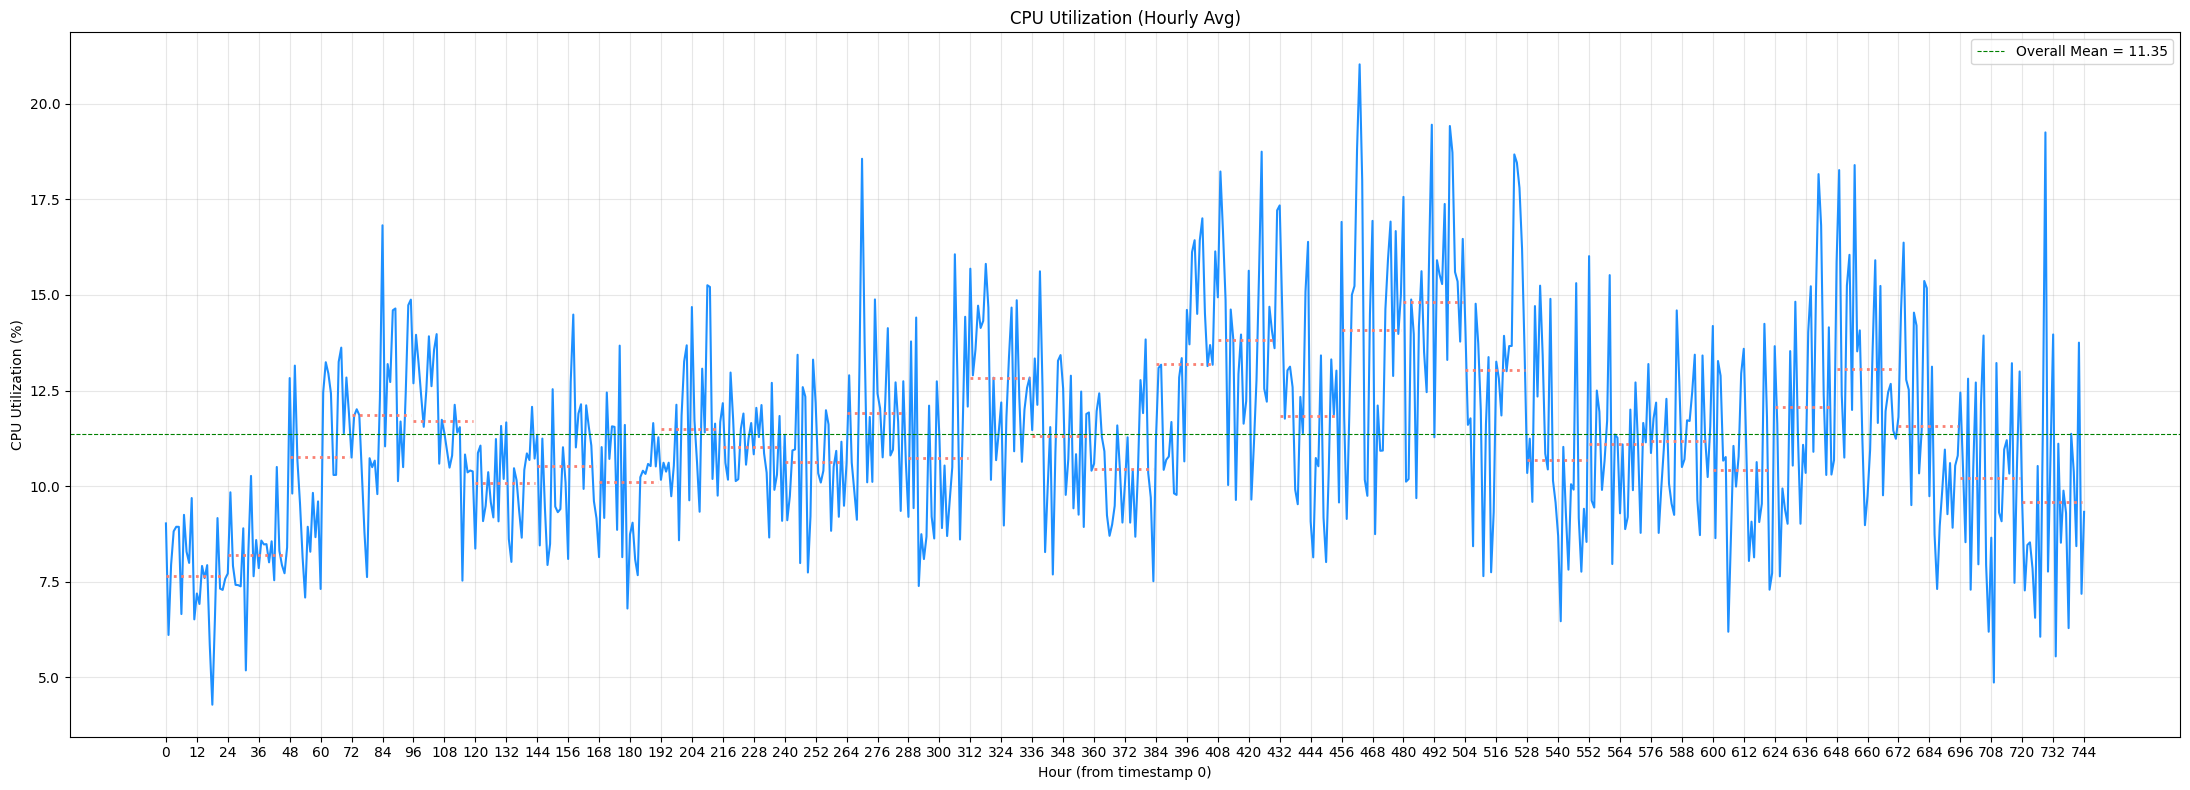

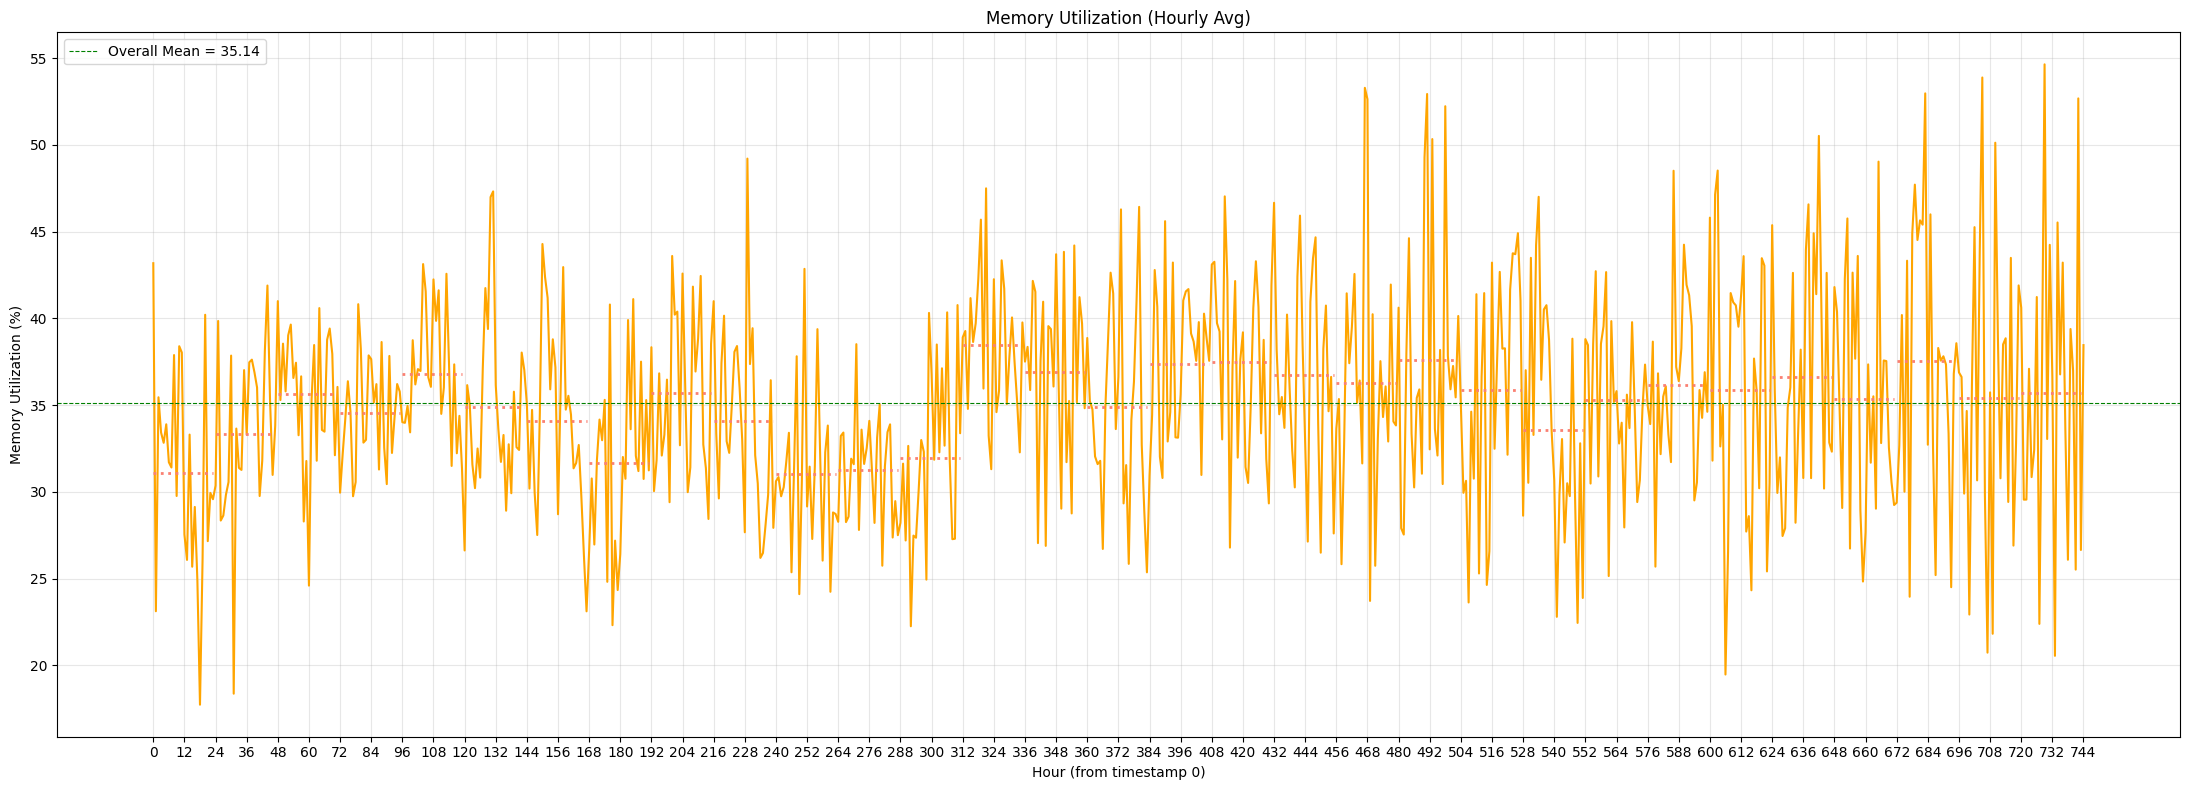

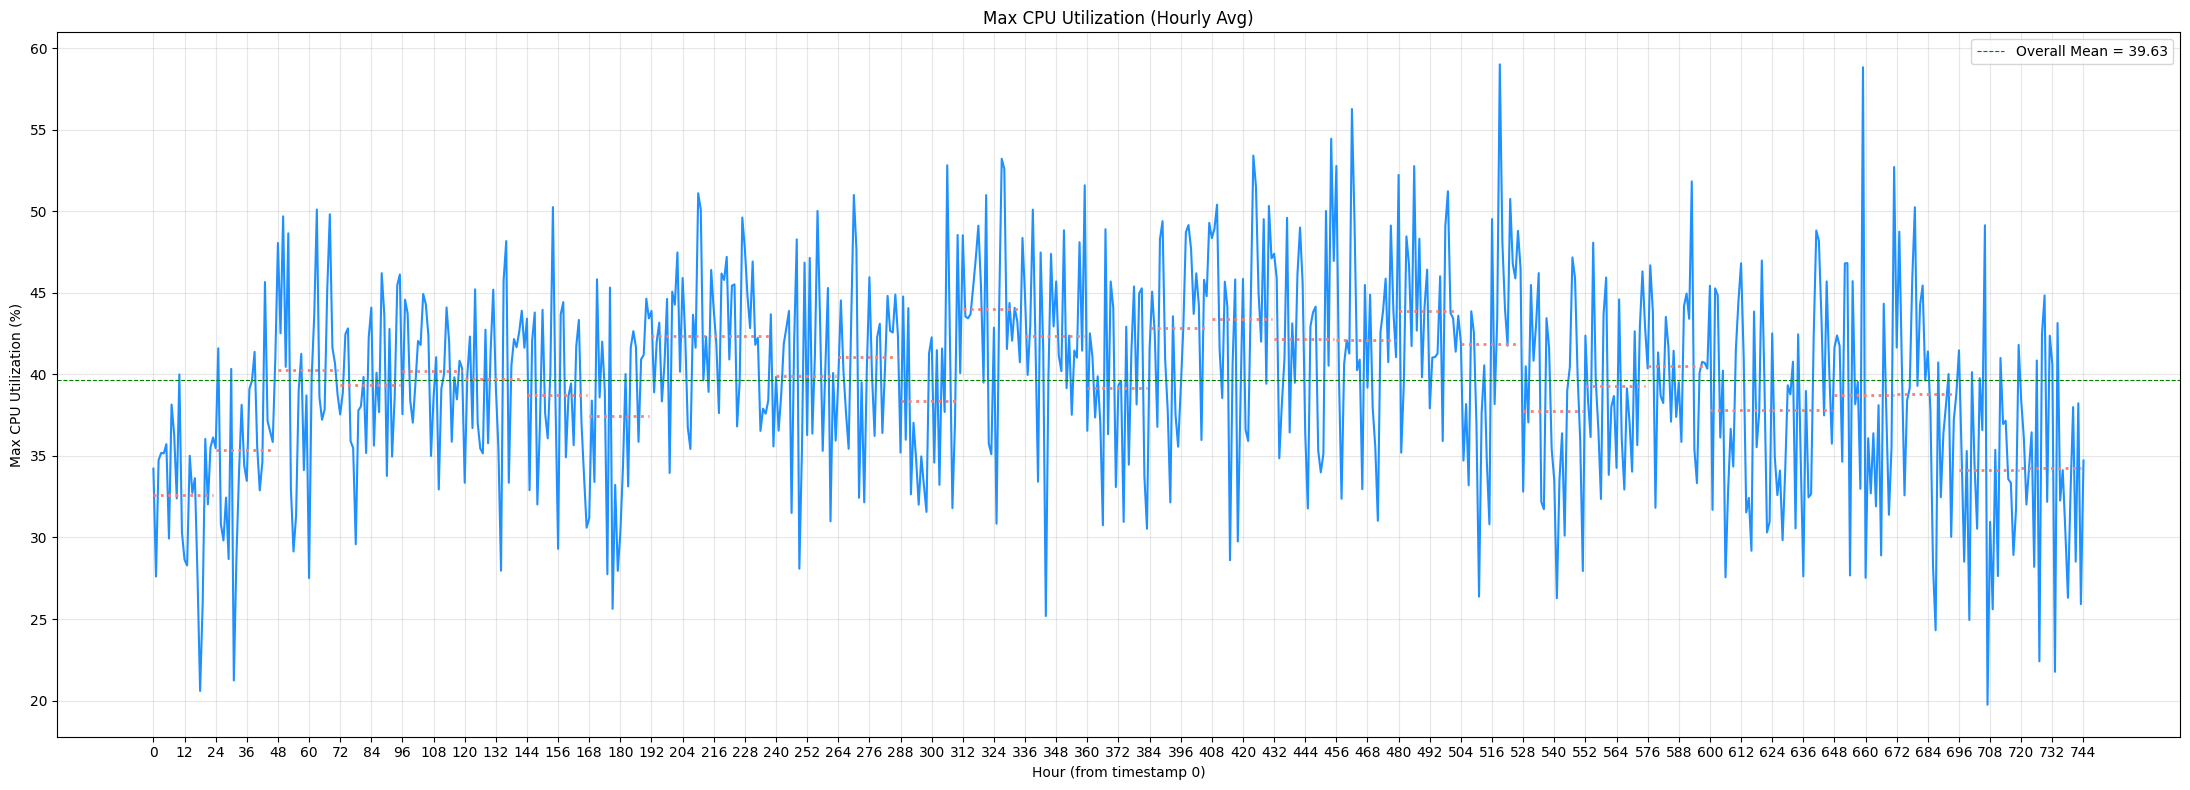

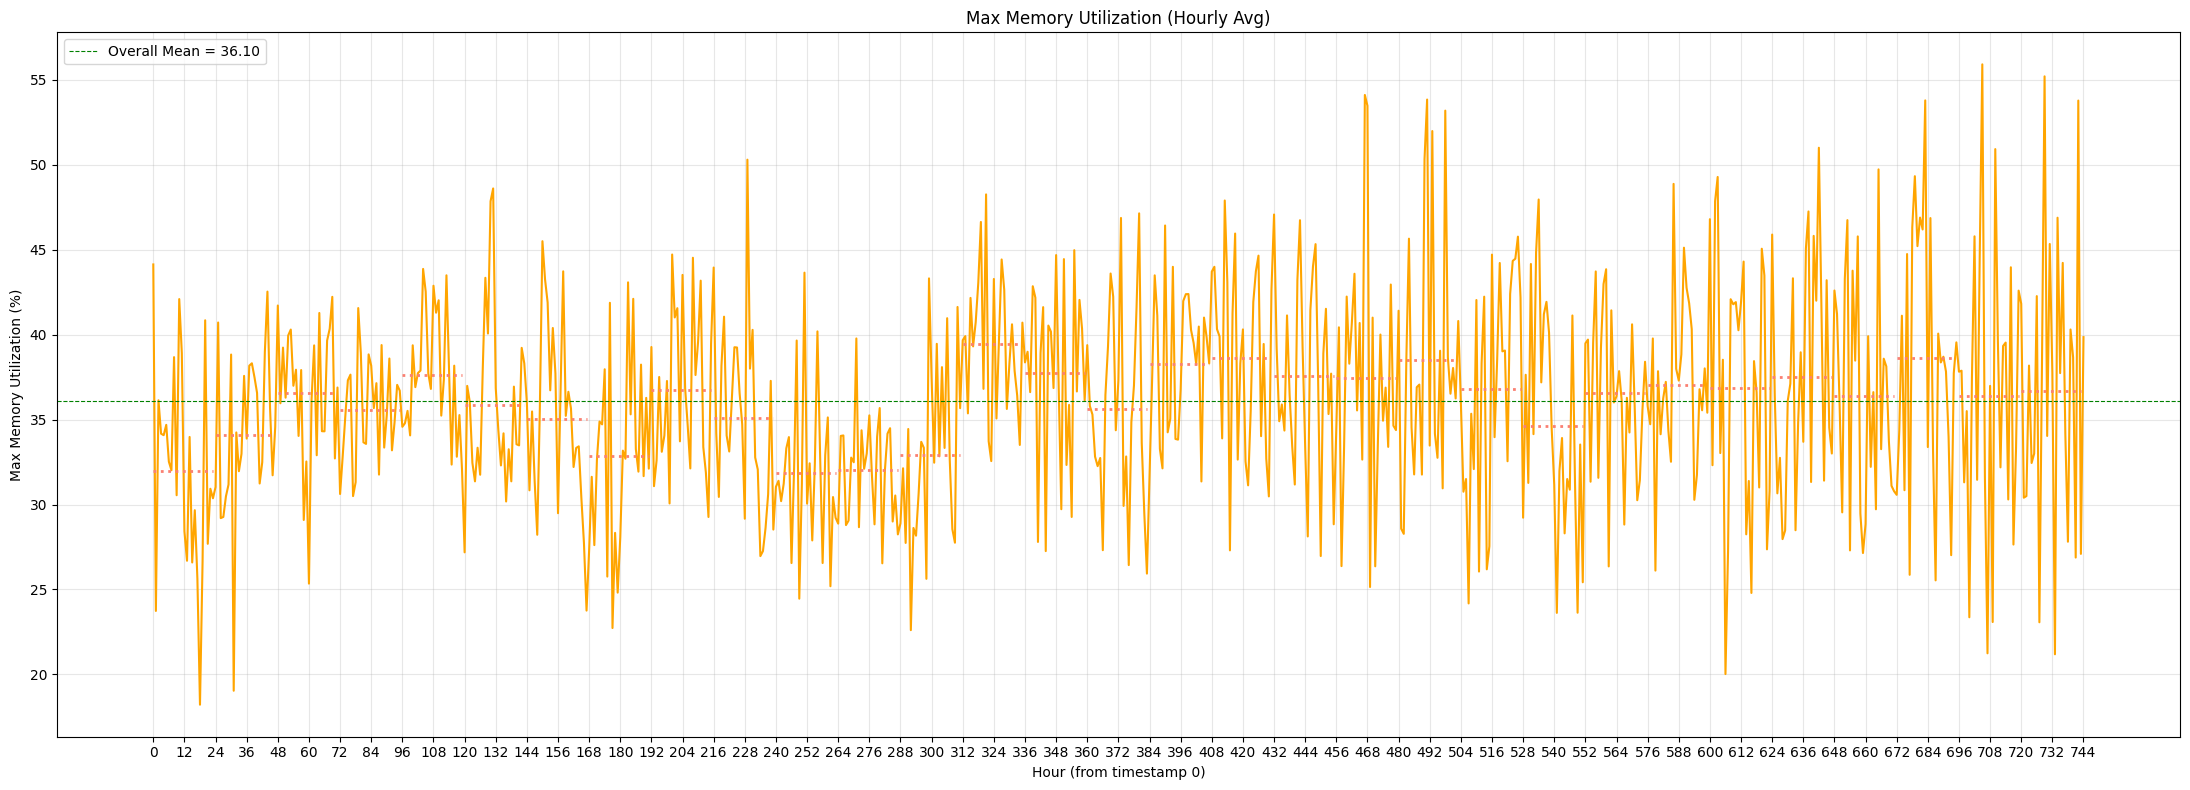

In [24]:
# Calculating hourly averages
hourly_avg = data_timeseries_util_plot.groupby('hour')[['cpus_util_perc', 'mem_util_perc', 'cpus_max_util_perc', 'mem_max_util_perc']].mean().reset_index()

def plot_with_24h_means(data, col_name, color, ylabel, title):
    plt.figure(figsize=(22, 8))
    plt.plot(data['hour'], data[col_name], color=color, linewidth=1.5)
    overall_mean = data[col_name].mean()
    plt.axhline(y=overall_mean, color='green', linestyle='--', linewidth=0.8, label=f'Overall Mean = {overall_mean:.2f}')

    max_hour = data['hour'].max()
    for start in range(0, max_hour + 1, 24):
        end = start + 24
        block = data[(data['hour'] >= start) & (data['hour'] < end)]
        if not block.empty:
            block_mean = block[col_name].mean()
            plt.hlines(y=block_mean, xmin=start, xmax=min(end - 1, max_hour), colors='salmon', linestyles='dotted', linewidth=2)

    plt.title(title)
    plt.xlabel('Hour (from timestamp 0)')
    plt.ylabel(ylabel)
    plt.xticks(ticks=np.arange(0, max_hour + 1, 12))
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'Google_{col_name}_plot')
    plt.show()

# Plotting CPU Utilization
plot_with_24h_means(data=hourly_avg, col_name='cpus_util_perc', color='dodgerblue', ylabel='CPU Utilization (%)', title='CPU Utilization (Hourly Avg)')

# Plotting Memory Utilization
plot_with_24h_means(data=hourly_avg, col_name='mem_util_perc', color='orange', ylabel='Memory Utilization (%)', title='Memory Utilization (Hourly Avg)')

# Plotting Max CPU Utilization
plot_with_24h_means(data=hourly_avg, col_name='cpus_max_util_perc', color='dodgerblue', ylabel='Max CPU Utilization (%)', title='Max CPU Utilization (Hourly Avg)')

# Plotting Max Memory Utilization
plot_with_24h_means(data=hourly_avg, col_name='mem_max_util_perc', color='orange', ylabel='Max Memory Utilization (%)', title='Max Memory Utilization (Hourly Avg)')

In [25]:
!pip install xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [26]:
data_to_predict = instance_data[['start_hour', 'start_time', 'end_time', 'collection_id', 'machine_id', 'type', 'scheduling_class', 'priority', 'cpus_util_perc', 'mem_util_perc']]

data_to_predict["total_time_running"] = data_to_predict['end_time'] - data_to_predict['start_time']
data_to_predict["start_hour"] = data_to_predict["start_hour"] % 24
training_data_X, testing_data_X, training_data_Y, testing_data_Y = train_test_split(data_to_predict[["start_hour", "total_time_running", "type", "priority", "scheduling_class"]], data_to_predict["cpus_util_perc"], test_size = 0.05)

In [27]:
xgboost_regressor_model = XGBRegressor(n_estimators = 1500)
xgboost_regressor_model.fit(training_data_X, training_data_Y)
avg_cpu_prediction_values = xgboost_regressor_model.predict(testing_data_X)
print(avg_cpu_prediction_values)
root_mean_squared_error(testing_data_Y, avg_cpu_prediction_values)

[ 5.660599   1.3851129 16.359755  ...  3.7535024 13.478291  15.161158 ]


9.203477644794843

In [28]:
diff_in_prediction_vals_from_truth = (abs(avg_cpu_prediction_values - testing_data_Y)).to_list()
prediction_in_range_counter = 0
for curr_diff in diff_in_prediction_vals_from_truth:
    if curr_diff <= 10:
        prediction_in_range_counter = prediction_in_range_counter + 1
model_avg_cpu_pred_accuracy = prediction_in_range_counter * 100 / len(diff_in_prediction_vals_from_truth)
print("Model's Average CPU Utilization Precition accuracy is:", str(model_avg_cpu_pred_accuracy) + "%")

Model's Average CPU Utilization Precition accuracy is: 81.80675287356321%


In [29]:
data_to_predict = instance_data[['start_hour', 'start_time', 'end_time', 'collection_id', 'machine_id', 'type', 'scheduling_class', 'priority', 'cpus_util_perc', 'mem_util_perc']]

data_to_predict["total_time_running"] = data_to_predict['end_time'] - data_to_predict['start_time']
data_to_predict["start_hour"] = data_to_predict["start_hour"] % 24
training_data_X, testing_data_X, training_data_Y, testing_data_Y = train_test_split(data_to_predict[["start_hour", "total_time_running", "type", "priority", "scheduling_class"]], data_to_predict["mem_util_perc"], test_size = 0.05)

In [30]:
xgboost_regressor_model = XGBRegressor(n_estimators = 1500)
xgboost_regressor_model.fit(training_data_X, training_data_Y)
avg_mem_prediction_values = xgboost_regressor_model.predict(testing_data_X)
print(avg_mem_prediction_values)
root_mean_squared_error(testing_data_Y, avg_mem_prediction_values)

[29.770962   33.72831    45.14325    ...  0.99865186 30.834314
  1.3498333 ]


15.808012696849385

In [31]:
diff_in_prediction_vals_from_truth = (abs(avg_mem_prediction_values - testing_data_Y)).to_list()
prediction_in_range_counter = 0
for curr_diff in diff_in_prediction_vals_from_truth:
    if curr_diff <= 10:
        prediction_in_range_counter = prediction_in_range_counter + 1
model_avg_mem_pred_accuracy = prediction_in_range_counter * 100 / len(diff_in_prediction_vals_from_truth)
print("Model's Average Memory Utilization Precition accuracy is:", str(model_avg_mem_pred_accuracy) + "%")

Model's Average Memory Utilization Precition accuracy is: 67.25933908045977%


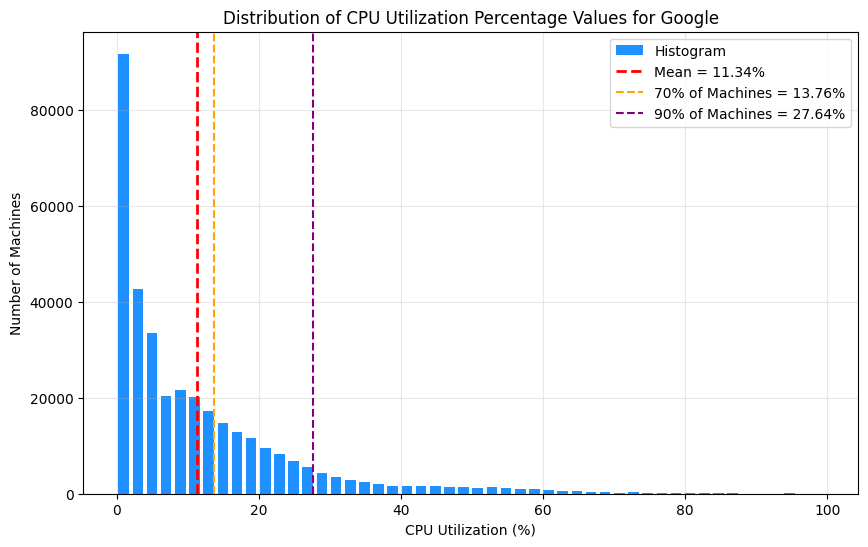

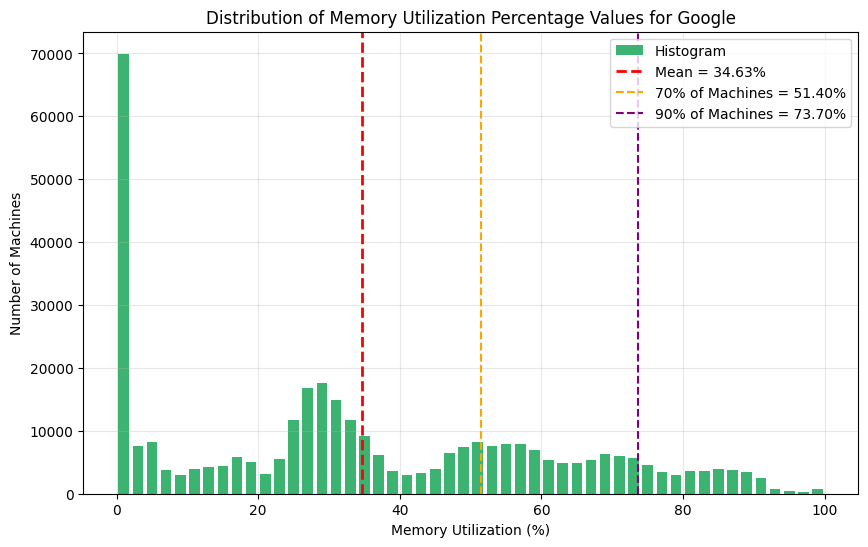

In [32]:
def plot_resource_analysis(dataframe, col_name):
    plt.figure(figsize=(10, 6))
    data = dataframe[col_name].dropna()
    mean_val = data.mean()
    p70 = np.percentile(data, 70)
    p90 = np.percentile(data, 90)

    color = "dodgerblue" if col_name.startswith('cpu') else "mediumseagreen"
    plt.hist(data, bins=50, rwidth=0.75, color=color, label='Histogram')
    title_prefix = "CPU" if col_name.startswith('cpu') else "Memory"
    plt.title(f"Distribution of {title_prefix} Utilization Percentage Values for Google")
    plt.xlabel(f"{title_prefix} Utilization (%)")
    plt.ylabel("Number of Machines")
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_val:.2f}%')
    plt.axvline(p70, color='orange', linestyle='--', linewidth=1.5, label=f'70% of Machines = {p70:.2f}%')
    plt.axvline(p90, color='purple', linestyle='--', linewidth=1.5, label=f'90% of Machines = {p90:.2f}%')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig(f'google_{col_name}_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_resource_analysis(data_timeseries_util_plot, 'cpus_util_perc')
plot_resource_analysis(data_timeseries_util_plot, 'mem_util_perc')

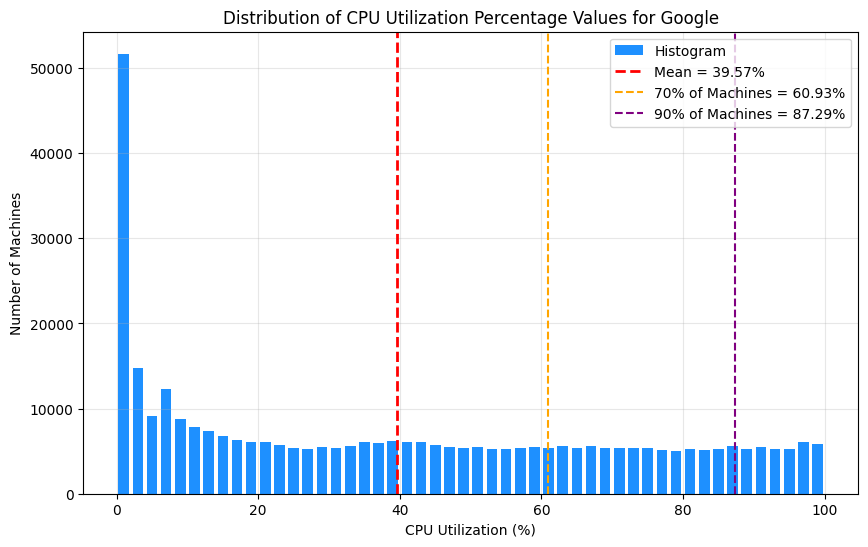

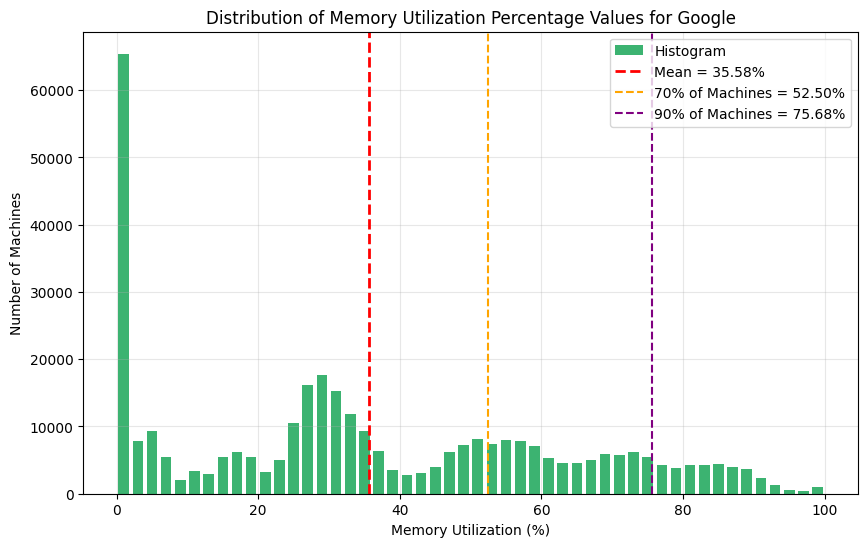

In [33]:
plot_resource_analysis(data_timeseries_util_plot, 'cpus_max_util_perc')
plot_resource_analysis(data_timeseries_util_plot, 'mem_max_util_perc')